In [1]:
%matplotlib inline
import pickle
import numpy             as np
import pandas            as pd
import matplotlib.pyplot as plt

from sklearn.ensemble        import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics         import confusion_matrix
from sklearn.metrics         import recall_score
from sklearn.metrics         import precision_score
from sklearn.metrics         import accuracy_score

In [2]:
data_path    = '../data/'
random_state = 142858

In [3]:
df = pd.read_csv(data_path + 'standardized_credit_card.csv')
df.head()

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,-0.694242,-0.044075,1.672773,0.973366,-0.245117,0.347068,0.193679,0.082637,0.331128,0.083386,...,-0.024923,0.382854,-0.176911,0.110507,0.246585,-0.392170,0.330892,-0.063781,0.244964,0
1,0.608496,0.161176,0.109797,0.316523,0.043483,-0.061820,-0.063700,0.071253,-0.232494,-0.153350,...,-0.307377,-0.880077,0.162201,-0.561131,0.320694,0.261069,-0.022256,0.044608,-0.342475,0
2,-0.693500,-0.811578,1.169468,0.268231,-0.364572,1.351454,0.639776,0.207373,-1.378675,0.190700,...,0.337632,1.063358,1.456320,-1.138092,-0.628537,-0.288447,-0.137137,-0.181021,1.160686,0
3,-0.493325,-0.112169,1.182516,-0.609727,-0.007469,0.936150,0.192071,0.316018,-1.262503,-0.050468,...,-0.147443,0.007267,-0.304777,-1.941027,1.241904,-0.460217,0.155396,0.186189,0.140534,0
4,-0.591330,0.531541,1.021412,0.284655,-0.295015,0.071999,0.479302,-0.226510,0.744326,0.691625,...,-0.012839,1.100011,-0.220123,0.233250,-0.395202,1.041611,0.543620,0.651816,-0.073403,0


In [4]:
def generate_dataset(df, non_anom_proportion):
    X                  = df.drop(['Class'], axis = 1)
    y                  = df['Class']
    fraud              = X[y == 1]
    non_fraud          = X[y == 0]
    fraud_number       = fraud.shape[0]
    undersampling_size = int(round(fraud_number * non_anom_proportion))
    small_X            = pd.concat([fraud, non_fraud.sample(undersampling_size, random_state = random_state)])
    small_y            = np.array([1] * fraud_number + [0] * undersampling_size)
    
    return small_X, small_y

In [5]:
def try_various_undersampling(df, start_value, end_value, steps, create_model, test_size = 0.15):
    train_confusion_matrices  = []
    test_confusion_matrices   = []
    full_confusion_matrices   = []
    recalls                   = []
    precisions                = []
    accuracies                = []
    undersampling_proportions = np.linspace(start_value, end_value, steps)
    X_full = df.drop(['Class'], axis = 1)
    y_full = df['Class']
    
    for prop in undersampling_proportions:
        X, y                             = generate_dataset(df, prop)
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = test_size, random_state = random_state)
        model                            = create_model()
        model.fit(X_train, y_train)
        train_confusion_matrices.append(confusion_matrix(y_train, model.predict(X_train)))
        y_test_ = model.predict(X_test)
        recalls.append(recall_score(y_test, y_test_))
        precisions.append(precision_score(y_test, y_test_))
        accuracies.append(accuracy_score(y_test, y_test_))
        test_confusion_matrices.append(confusion_matrix(y_test, y_test_))
        full_confusion_matrices.append(confusion_matrix(y_full, model.predict(X_full)))
        
    return undersampling_proportions, \
            train_confusion_matrices, \
            test_confusion_matrices, \
            full_confusion_matrices, \
            recalls, \
            precisions, \
            accuracies

In [6]:
create_model                                                 = lambda : RandomForestClassifier(n_estimators = 20, n_jobs = -1)
proportions, train_conf_mats, test_conf_mats, full_conf_mats, recalls, precisions, accuracies = try_various_undersampling(df, 1, 100, 25, create_model)

In [7]:
for i, prop in enumerate(proportions):
    print('########## %.2fx more of non fraud ###############' % prop)
    print('Training set confusion matrix')
    print(train_conf_mats[i])
    print('Test set confusion matrix')
    print(test_conf_mats[i])
    print('Full imbalanced dataset confusion matrix')
    print(full_conf_mats[i])
    print('##################################################\n')

########## 1.00x more of non fraud ###############
Training set confusion matrix
[[413   0]
 [  0 423]]
Test set confusion matrix
[[78  1]
 [ 5 64]]
Full imbalanced dataset confusion matrix
[[273771  10544]
 [     5    487]]
##################################################

########## 5.12x more of non fraud ###############
Training set confusion matrix
[[2147    0]
 [   5  409]]
Test set confusion matrix
[[375   0]
 [  8  70]]
Full imbalanced dataset confusion matrix
[[283324    991]
 [    13    479]]
##################################################

########## 9.25x more of non fraud ###############
Training set confusion matrix
[[3866    0]
 [   2  418]]
Test set confusion matrix
[[684   1]
 [  8  64]]
Full imbalanced dataset confusion matrix
[[283981    334]
 [    10    482]]
##################################################

########## 13.38x more of non fraud ###############
Training set confusion matrix
[[5585    0]
 [   3  423]]
Test set confusion matrix
[[994   1]
 [ 12  

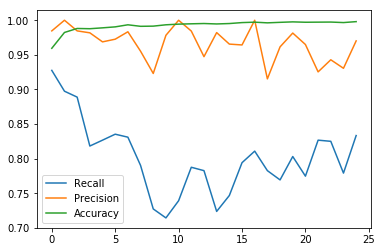

In [8]:
plt.plot(recalls   , label = 'Recall')
plt.plot(precisions, label = 'Precision')
plt.plot(accuracies, label = 'Accuracy')

plt.legend(loc = 3)